# CAO Points Analysis
## Acquiring the data
***

### 2021 [link](http://www.cao.ie/index.php?page=points&p=2021)

In [1]:
# import required libraries
import requests as rq             # Convenient HTTP requests.
import re                         # Regular expressions.
import numpy as np                # for numerical operations
import pandas as pd               # for data manipulation & generating dataframes

# display floats to 2 decimal places in dataframes
pd.options.display.float_format = "{:,.2f}".format

In [2]:
# Make a get request to 2021 CAO points URL
resp = rq.get('http://www2.cao.ie/points/l8.php')

# Check that value = 200 (in which case a connection is made).
resp

<Response [200]>

<br>

**Encoding note:<br>Error on server** <br>
The Server indicated one should decode as per: Content-Type: text/html; charset=iso-8859-1. However, one line of the html uses<br> 
\x96 which isn't defined in iso-8859-1. Therefore the similar decoding standard cp1252 will be  used. This standard is very similar but<br>
includes \x96.

In [3]:
# Specify encoding method 
resp.encoding = 'cp1252'

# Create a file path for the original data.
html_path = 'data/cao_2021_raw_data.html'

# Save original html file
with open(html_path, 'w') as f:
    f.write(resp.text)

In [4]:

def scrape_html_from_website(path, regex):
    
    num_lines = 0                                       # Keep track of courses counted in loop
    with open(path, 'w') as f:                          # Open the csv file for writing.          
        for line in resp.iter_lines():                      # Loop through lines of the response 
            dline = line.decode('cp1252')                       # decode the line 
            if regex.fullmatch(dline):                          # Match only the lines representing courses.       
                num_lines = num_lines + 1                           # Add one to the lines counter if match occured      
                course_code = dline[:5]                             # isolate course code 
                course_title = dline[7:57].strip()                  # isolate course title         
                course_points = re.split(' +', dline[60:])          # split string when on one or more spaces               
                
                if len(course_points) != 2:                   # if list length not equal to 2         
                    course_points = course_points[:2]         # then retain first two elements of list
                   
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                f.write(','.join(linesplit) + '\n')
    
    print('Total number of lines is lines is {}.\nThis was manually verified against\
"cao_2021_raw_data.html.'.format(num_lines))  
    
# Compile the regular expression for matching lines
    # ([A-Z]{2}[0-9]{3}) matches A-Z x2 characters, 0-9  x3 characters
    # (.*) Matches any single character except newline zero or more times 
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')  

# write parsed data to csv file
write_path = 'data/cao_2021_final_data.csv'         
scrape_html_from_website(write_path, re_course)

Total number of lines is lines is 949.
This was manually verified against"cao_2021_raw_data.html.


### 2020 [link](http://www2.cao.ie/points/CAOPointsCharts2020.xlsx)
***

In [5]:
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

# request url and write data to disc
resp = rq.get(url2020)                  

# open file for writing in binary mode
output = open('data/cao_2020_raw_data.xlsx', 'wb')    
output.write(resp.content)
output.close() 

In [6]:
def data_handler_2020(url):       
    df = pd.read_excel(url, skiprows = 10)               # read excel & skip first 10 rows (irrelevant)
    df = df.iloc[: , :-8]                                # drop last 8 columns  
    df = df.loc[df.loc[:, 'LEVEL'] == 8]                 # filter df for level 8 courses          
    return df

df_2020 = data_handler_2020(url2020)

# Save dataframe to disk.
write_path = 'data/cao_2020_final_data.csv'
df_2020.to_csv(write_path, encoding = "utf-8")

In [7]:
# Spot check a random row.
print(df_2020.iloc[189])

# Spot check last row.
print(df_2020.iloc[-1])

CATEGORY (i.e.ISCED description)    Engineering and engineering trades
COURSE TITLE                                     Aerospace Engineering
COURSE CODE2                                                     CW568
R1 POINTS                                                          380
R1 Random *                                                        NaN
R2 POINTS                                                          NaN
R2 Random*                                                         NaN
EOS                                                                380
EOS Random *                                                       NaN
EOS Mid-point                                                      442
LEVEL                                                                8
HEI                                    Institute of Technology, Carlow
Test/Interview #                                                   NaN
avp                                                                NaN
v     

### 2019

In [8]:
import urllib3
import pdfplumber
import io


def scrape_pdf_from_website(url):
    http = urllib3.PoolManager()                                   # instansiate pool manager object for sending requests
    temp_binary = io.BytesIO()                                     # create instance for storing binary data
    temp_binary.write(http.request("GET", url).data)               # request url data and write to temp_binary storage
    
    data_final = ''  
    with pdfplumber.open(temp_binary) as pdf:                      # open storage object      
        for page in pdf.pages:                                         # iterate pages of pdf object
            data = page.extract_text()                                 # extract text of page
            data_final += data                                         # concatenates text to data_final variable
    return data_final

url  = 'http://www2.cao.ie/points/lvl8_19.pdf'
pdf_text = scrape_pdf_from_website(url)

In [9]:
def data_handler_2019(regex, line_splitter, text):
    
    df_data = []                                                   # placeholder to add list of rows to
    #print(text)
    #for char in text:                                         # iterate file chars  
    for match in re.finditer(regex, text):                    # iterate matches each line
        course_code = match.group()[0:6]                           # isolate course code
        rest_of_line =  match.group()[6:]                          # isolate all of line after course code 
        rest_of_line = re.split(line_splitter ,rest_of_line)           # split lines using passed criteria
        df_data.append([course_code] + rest_of_line)
                        
    df = pd.DataFrame(df_data)                                # convert array to dataframe
    return df


# regex statement (will isolate all lines starting with course code)
regex = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')
line_split_conditions = '(#\d{3}\* |#\d{2}\* |\d{3}\* |\d{2}\* |\d{3} |\d{2} |#\d{3} |#\d{2} |# \+matric|#)'

df_2019 = data_handler_2019(regex, line_split_conditions, pdf_text)
df_2019.to_csv('data/cao_2019_final.csv')

print('NB: it was verified as of 26/11/2021 that there were {} courses exactly in the CAO 2019 points list.'
      .format(len(df_2019.index)))


NB: it was verified as of 26/11/2021 that there were 930 courses exactly in the CAO 2019 points list.


In [10]:
# Spot check a random row.
print(df_2019.iloc[50])

# Spot chcek last row.
print(df_2019.iloc[-1])

0        CW708 
1    Law - LLB 
2          298 
3           328
Name: 50, dtype: object
0                                       WD230 
1    Mechanical and Manufacturing Engineering 
2                                         273 
3                                          348
Name: 929, dtype: object


<br>

## Joining the data

### Get unique course codes
***

In [11]:
# read in 2021 data from csv and convert to dataframe
df_2021 =  pd.read_csv('data/cao_2021_final_data.csv', encoding ='cp1252', header = None)

In [12]:
# isolate wanted cols from 2020 data and then rename them
df_2020 = df_2020[['COURSE CODE2', 'COURSE TITLE', 'CATEGORY (i.e.ISCED description)', 'HEI', 'R1 POINTS', 'R2 POINTS','R1 Random *', 'R2 Random*', 'Test/Interview #']]
df_2020.columns = ['code', 'title', 'category', 'institution', 'points_r1_2020', 'points_r2_2020', '*r1_2020', '*r2_2020', '#Test/Interview2020']    
df_2021.columns = ['code', 'title', 'points_r1_2021', 'points_r2_2021']  
df_2019.columns = ['code', 'title', 'points_r1_2019', 'points_r2_2019'] 

# remove trailing / leading spaces on code col of all dfs
df_2021['code'] = df_2021['code'].str.strip() 
df_2020['code'] = df_2020['code'].str.strip()
df_2019['code'] = df_2019['code'].str.strip() 

In [13]:
# isolate code and title cols (first two cols) accross all datframes
courses_2019 = df_2019[['code', 'title']]
courses_2020 = df_2020[['code', 'title']]              
courses_2021 = df_2021[['code', 'title']]

In [14]:
# append the three dataframes and sort code alphabetically
all_courses = pd.concat([courses_2021, courses_2020, courses_2019], ignore_index = True)
all_courses.sort_values('code')

print('Shapes:\ncourses_2019 = {}\ncourses_2020 = {}\ncourses_2021 = {}\nall_courses  = {}'
      .format(courses_2019.shape,courses_2020.shape,courses_2021.shape, all_courses.shape))

Shapes:
courses_2019 = (930, 2)
courses_2020 = (1027, 2)
courses_2021 = (949, 2)
all_courses  = (2906, 2)


In [15]:
# return a count on boolean check for all code rows that are duplicates
duplicated_code_rows = all_courses[all_courses.duplicated(subset = ['code'])].count()
duplicated_code_rows

code     1692
title    1692
dtype: int64

In [16]:
# Returns a data frame with duplciates removed (based only on code)
# i.e row count = concat (2906) - duplicated () = unique (2010)
all_courses.drop_duplicates(subset = ['code'], inplace = True, ignore_index = True)
all_courses.shape

(1214, 2)

### Join Points Data
***

In [17]:
# join cols from 3x years while omitting the first two col names (code & title)
# adopted from: https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns

# declarea wanted df and their cols in a list
dfs = [all_courses, 
       df_2019[['code', 'points_r1_2019', 'points_r2_2019']],
       df_2020[['code', 'points_r1_2020', 'points_r2_2020','*r1_2020', '*r2_2020', '#Test/Interview2020']], 
       df_2021[['code', 'points_r1_2021', 'points_r2_2021']]
      ]

In [18]:
# set index val for each df
dfs = [df.set_index('code') for df in dfs]      

# join all dfs after first to the first df
all_courses = dfs[0].join(dfs[1:])

In [19]:
all_courses.head(5)

,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021
code,,,,,,,,,,
AL801,Software Design for Virtual Reality and Gaming,304,328,303,NaN,NaN,NaN,NaN,300,NaN
AL802,Software Design in Artificial Intelligence for...,301,306,332,NaN,NaN,NaN,NaN,313,NaN
AL803,Software Design for Mobile Apps and Connected ...,309,337,337,NaN,NaN,NaN,NaN,350,NaN
AL805,Computer Engineering for Network Infrastructure,329,442,333,NaN,NaN,NaN,NaN,321,NaN
AL810,Quantity Surveying,307,349,319,NaN,NaN,NaN,NaN,328,NaN


### Join Institute Data
***

In [20]:
# reset 2021 df index and define its code & institution cols  as new df 
institution_df = df_2020.reset_index()[['code', 'institution']]     

# make new col with code letters, will be used to join institutes
institution_df['institution_letters'] = institution_df['code'].str[:2]   

# drop records that are duplicated (based on institution)
institution_df.drop_duplicates(subset ='institution_letters', keep = "last", inplace = True)

# drop code col
institution_df.drop('code', axis = 1, inplace = True)
institution_df.set_index('institution_letters', inplace = True)

print(institution_df.shape)
institution_df.head(5)

(34, 1)


,institution
institution_letters,
AC,American College
AD,National College of Art and Design
AL,Athlone Institute of Technology
AS,St. Angela`s College
CI,Irish College of Humanities & Applied Sciences


In [21]:
# make temp df to allow concat of missing institutions (this was manually checked on 01 Dec 2021)
# declare new row dict
new_rows = {'institution_letters': ['BN', 'BY', 'DT', 'TA'], 
            'institution': ['Technological University Dublin Blanchardstown Campus',
                            'IBAT College Dublin ',
                            'Technological University Dublin City Campus',
                            'Technological University Dublin Tallaght Campus']}
# convert dict to df
temp_df = pd.DataFrame.from_dict(new_rows).set_index('institution_letters')

# concat  temp df to institution df
institution_df = pd.concat([institution_df, temp_df])

print(institution_df.shape)
institution_df.tail(5)

(38, 1)


,institution
institution_letters,
WD,Waterford Institute of Technology
BN,Technological University Dublin Blanchardstown...
BY,IBAT College Dublin
DT,Technological University Dublin City Campus
TA,Technological University Dublin Tallaght Campus


In [22]:
# Use institution_df as a lookup table to populate institures on main df

# make new col with code letters for all_courses df
all_courses['institution_letters'] = all_courses.index.str[:2]   

# reset index and set institution_letters as new index before joining to institution_df
all_courses = all_courses.reset_index().set_index('institution_letters').join(institution_df['institution'])
all_courses.head(5)

,code,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021,institution
institution_letters,,,,,,,,,,,,
AC,AC120,International Business,234,269,209,NaN,NaN,NaN,NaN,294,294,American College
AC,AC137,Liberal Arts,252,275,252,NaN,NaN,NaN,NaN,271,270,American College
AD,AD101,First Year Art and Design (Common Entry portfo...,# +matric,550,#+matric,NaN,NaN,NaN,#,#554,NaN,National College of Art and Design
AD,AD102,Graphic Design and Moving Image Design (portfo...,# +matric,635,#+matric,NaN,NaN,NaN,#,#538,NaN,National College of Art and Design
AD,AD103,Textile and Surface Design and Jewellery and O...,# +matric,545,#+matric,NaN,NaN,NaN,#,#505,NaN,National College of Art and Design


### Join Category Data
***

In [23]:
# reset 2021 df index and define its code & institution cols  as new df 
category_df = df_2020[['code', 'category']].set_index('code') 

In [24]:
# Use category df as a lookup table to populate categories on main df
# reset index and set institution_letters as new index before joining to institution_df
all_courses = all_courses.reset_index().set_index('code').join(category_df['category'])
all_courses.head(5)

,institution_letters,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021,institution,category
code,,,,,,,,,,,,,
AC120,AC,International Business,234,269,209,NaN,NaN,NaN,NaN,294,294,American College,Business and administration
AC137,AC,Liberal Arts,252,275,252,NaN,NaN,NaN,NaN,271,270,American College,Humanities (except languages)
AD101,AD,First Year Art and Design (Common Entry portfo...,# +matric,550,#+matric,NaN,NaN,NaN,#,#554,NaN,National College of Art and Design,Arts
AD102,AD,Graphic Design and Moving Image Design (portfo...,# +matric,635,#+matric,NaN,NaN,NaN,#,#538,NaN,National College of Art and Design,Arts
AD103,AD,Textile and Surface Design and Jewellery and O...,# +matric,545,#+matric,NaN,NaN,NaN,#,#505,NaN,National College of Art and Design,Arts


<br>

## Reformatting the data
### Move special characters into new column
***

As per the CAO website certain characters / strings are present in the points data to give more information.<br>
- Hastag symbol (#) : Course has a Test / Interview / Portfolio / Audition <br>
- Asterix symbol (*): Course was not offered to everyone.<br>

In [25]:
## pre check occurances 2019 and 2021 years (as 2020 data will be parsed in same function as 2019)

# define cases of character occurances on relevant cols (these will be printed later)
# locate choose subset of df then loc where index values are equal to elements in list
pre_check_2019 = all_courses[['points_r1_2019', 'points_r2_2019']].loc[all_courses.index.isin(['AS110','DC004', 'GY501'])]
pre_check_2020 = all_courses[['*r1_2020', '*r2_2020', '#Test/Interview2020']].loc[all_courses.index.isin(['CK120','AD204', 'DN400'])]

In [26]:
# parse 2019 and 2021 # and * characters into one col
def move_special_characters(col_one, col_two):
    '''This function accepts two cols, performs regex on each col to return result in array'''
    # regex for '*#' case adopted from https://newbedev.com/regex-i-want-this-and-that-and-that-in-any-order
        # this checks for any occurance of # or * anywhere in the string
    
    array = np.where((all_courses[col_one].str.contains('^(?=.*#)(?=.*\*).*$', na = False) | 
                      all_courses[col_two].str.contains('^(?=.*#)(?=.*\*).*$' , na = False)), '#*',                
            np.where((all_courses[col_one].str.contains('\*', na = False) | 
                      all_courses[col_two].str.contains('\*', na = False)), '*',
            np.where((all_courses[col_one].str.contains('#', na = False) | 
                      all_courses[col_two].str.contains('#', na = False)), '#', 
                       'NaN')))   
    return array


# define variable as result of function call, with 2 cols passsed
special_chars_2019_col = move_special_characters('points_r1_2019', 'points_r2_2019')
special_chars_2021_col = move_special_characters('points_r1_2021', 'points_r2_2021')

# APush returned arrays to a list and add list as new col to df 
all_courses['special_chars_2019'] = special_chars_2019_col.tolist()
all_courses['special_chars_2021'] = special_chars_2021_col.tolist()


In [27]:
# parse 2020 characters into one col                     
all_courses['special_chars_2020'] = np.where(((pd.isna(all_courses['*r1_2020']) &
                                               pd.isna(all_courses['*r2_2020'])) &   
                                               all_courses['#Test/Interview2020'].str.contains('#')), '#',
                                             
                                    np.where(((pd.isna(all_courses['*r1_2020']) &
                                               pd.isna(all_courses['*r2_2020'])) &
                                               pd.isna(all_courses['#Test/Interview2020'])), '',
                                             
                                    np.where(((all_courses['*r1_2020'].str.contains('\*', na = False) |
                                               all_courses['*r2_2020'].str.contains('\*', na = False)) &
                                               all_courses['#Test/Interview2020'].str.contains('#')), '*#',
                                             
                                    np.where(((all_courses['*r1_2020'].str.contains('\*', na = False) |
                                               all_courses['*r2_2020'].str.contains('\*', na = False)) &
                                               pd.isna(all_courses['#Test/Interview2020'])), '*',
                                               'NaN'))))

In [28]:
## post parse check 
post_check_2019 = all_courses['special_chars_2019'].loc[all_courses.index.isin(['AS110','DC004', 'GY501'])]
post_check_2020 = all_courses['special_chars_2020'].loc[all_courses.index.isin(['CK120','AD204', 'DN400'])]

# print and confirm the parse worked on selected cases
#print('pre_check_2019', '\n', pre_check_2019)
print('pre_check_2019', '\n', pre_check_2019, '\n')
print('post_check_2019', '\n', post_check_2019, '\n\n')
print('pre_check_2020', '\n', pre_check_2020, '\n')
print('post_check_2020', '\n', post_check_2020, '\n')

pre_check_2019 
       points_r1_2019 points_r2_2019
code                               
AS110          391*             409
DC004              #            357
GY501         #726*             731 

post_check_2019 
 code
AS110     *
DC004     #
GY501    #*
Name: special_chars_2019, dtype: object 


pre_check_2020 
       *r1_2020 *r2_2020 #Test/Interview2020
code                                       
AD204      NaN      NaN                   #
CK120        *        *                 NaN
DN400      NaN        *                   # 

post_check_2020 
 code
AD204     #
CK120     *
DN400    *#
Name: special_chars_2020, dtype: object 



### Convert Point Columns To Numeric

In [29]:
# remove special chars from 2021 and 2019 point cols
for col in all_courses.columns:
    if col in ['points_r1_2019', 'points_r2_2019','points_r1_2021', 'points_r2_2021']:
        all_courses[col] = all_courses[col].str.replace('#+matric', '', regex = True).str.replace('\*', '', regex = True).str.replace('#', '', regex = True).str.strip()
    else:
        pass
    all_courses.to_csv('after parse.csv')
    # conver all cols to numeric, cast erros as NaN
    if 'points' in col:
        all_courses[col]  = pd.to_numeric(all_courses[col], errors = 'coerce')

## Plotting The Data
### Boxlot
***

In [30]:
import matplotlib.pyplot as plt             # for plotting
import seaborn as sns                       # for plotting
plt.rcParams['font.size'] = 13              # set default plot font size 
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


              The boxplot shows that the R1 Points mean (yellow triangle) increased from 2019 
              through to 2021. The median, 25th percentile and 75th percentile all show a similar
              increase.



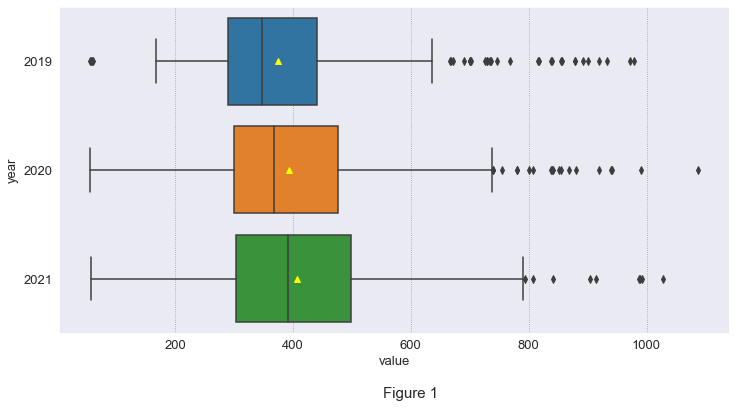

In [31]:
points_cols = ['points_r1_2019', 'points_r1_2020', 'points_r1_2021']

# unpivot df from wide to long (this will allow use of hue parameter in seaborn boxplot)
melted_df = pd.melt(all_courses.reset_index(), id_vars=['category'], value_vars = points_cols)

# add year col
melted_df['year'] = np.where(melted_df['variable'].str.contains('2021'), '2021',
                       np.where(melted_df['variable'].str.contains('2020'), '2020',
                               np.where(melted_df['variable'].str.contains('2019'), '2019', '')))

fig, ax = plt.subplots(figsize = (12, 6))
plt.figtext(0.5, -0.025, 'Figure 1', wrap = True, fontsize = 15)

# R1 Boxplot, filter melted df variable col by r1 points
sns.boxplot(data = melted_df[melted_df['variable'].isin(points_cols[:3])], x = 'value', y = 'year', showmeans = True, 
            meanprops={'markerfacecolor':'yellow', 'markeredgecolor':'yellow'})

string_spacer = [' ' * 14 for i in range(3)]
print('\n{}The boxplot shows that the R1 Points mean (yellow triangle) increased from 2019 \n\
{}through to 2021. The median, 25th percentile and 75th percentile all show a similar\n\
{}increase.\n'.format(*string_spacer))

### Histogram (with KDE)
***


              The bar distribution and KDE plots shows that the R1 Points have somewhat of a normal distribution with
              a second mode starting to appear in 2020 at approx 500 Points. This second mode is more prevelant in 2021
              making the distribution bi-modal due to higher points being offered on this year.



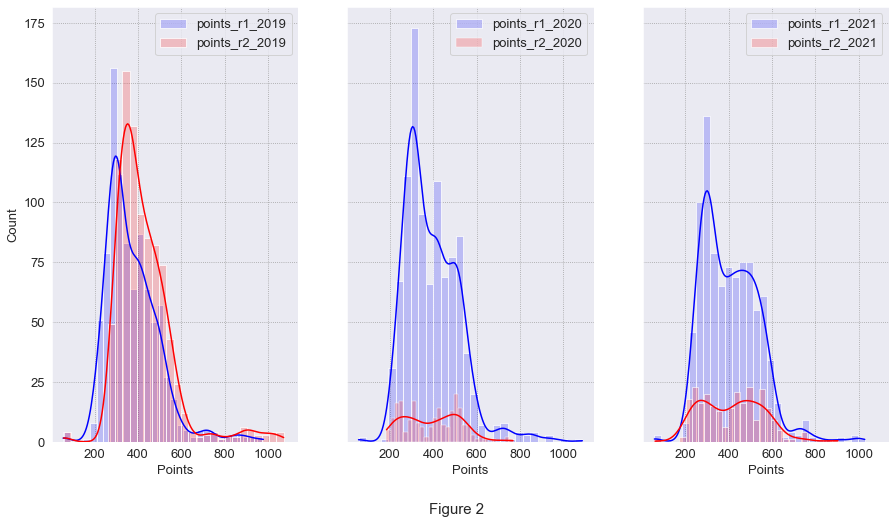

In [32]:

fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (15, 8))
plt.figtext(0.5, 0, 'Figure 2', wrap = True, horizontalalignment = 'center', fontsize = 15); 

def plot_hist_multi(df, plot_ref): 

    sns.histplot(data = df, x = df.iloc[:, 0], ax = ax[plot_ref], label = df.columns[0], kde = True, 
                 color = 'blue', alpha = 0.2, bins = 30)
    
    sns.histplot(data = df, x = df.iloc[:, 1], ax = ax[plot_ref], label = df.columns[1], kde = True, 
                 color = 'red', alpha = 0.2, bins = 30)
    
    ax[plot_ref].set_xlabel('Points')    
    ax[plot_ref].legend()

plot_hist_multi(all_courses[['points_r1_2019', 'points_r2_2019']], plot_ref = (0))  
plot_hist_multi(all_courses[['points_r1_2020', 'points_r2_2020']], plot_ref = (1))  
plot_hist_multi(all_courses[['points_r1_2021', 'points_r2_2021']], plot_ref = (2)) 


string_spacer = [' ' * 14 for i in range(4)]
print('\n{}The bar distribution and KDE plots shows that the R1 Points have somewhat of a normal distribution with\n\
{}a second mode starting to appear in 2020 at approx 500 Points. This second mode is more prevelant in 2021\n\
{}making the distribution bi-modal due to higher points being offered on this year.\n'.format(*string_spacer))

### Average Points (R1) by Institute
***

In [33]:
# group by institute and get mean
institute_r1_comparison = all_courses[['institution', 'points_r1_2019', 'points_r1_2020', 'points_r1_2021']].groupby('institution').mean()

# calc mean for round 1 over 3 years in new col       
institute_r1_comparison['mean_r1_points'] = institute_r1_comparison.loc[: , 'points_r1_2019' : 'points_r1_2021'].mean(axis = 1)

# sort mean points ascending   
institute_r1_comparison.sort_values(by = 'mean_r1_points', ascending = False, inplace = True)
institute_r1_comparison.head(5)

,points_r1_2019,points_r1_2020,points_r1_2021,mean_r1_points
institution,,,,
RCSI University of Medicine & Health Sciences,469.00,626.00,647.67,580.89
"Dun Laoghaire Institute of Art, Design and Technology",561.29,538.00,524.25,541.18
Trinity College Dublin,481.79,478.48,537.89,499.39
University College Dublin (NUI),445.41,478.36,513.67,479.15
University College Cork (NUI),438.67,454.87,481.68,458.41



                                                    Figure 3 shows a large range for the Average R1 CAO points 
                                                    offered by the given instituions from 2019 - 2021. Not
                                                    surprisingly Dublin is present 6 times in the top 10.



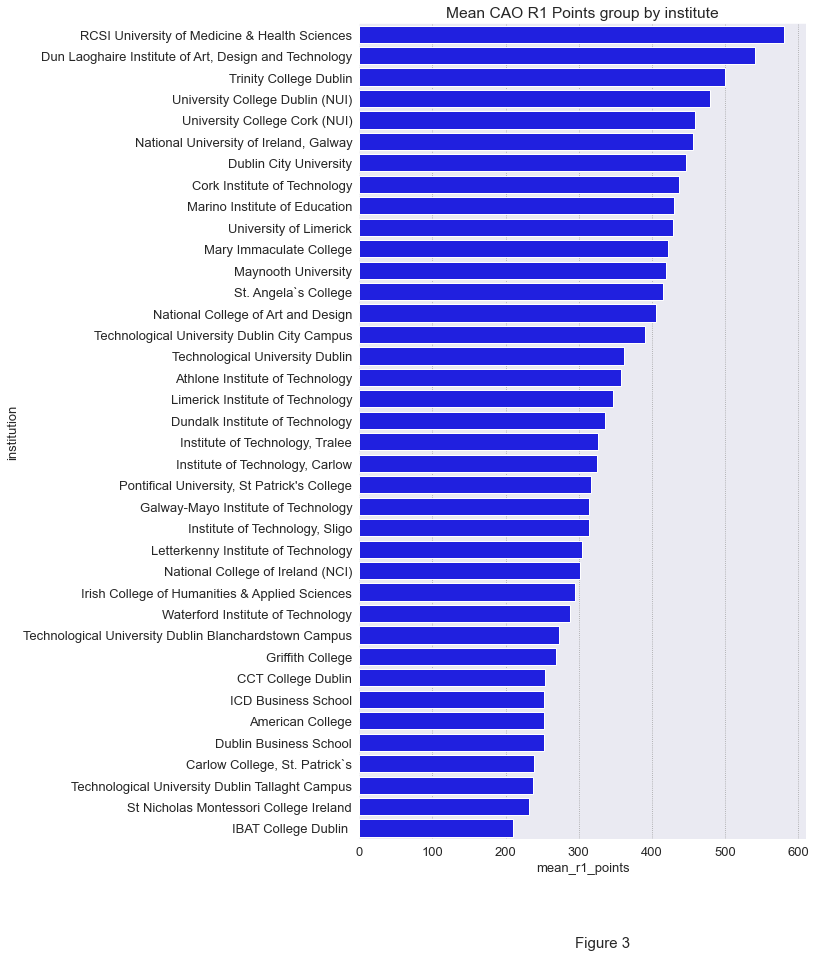

In [34]:
fig, ax = plt.subplots(figsize = (8, 15))


ax = sns.barplot(data = institute_r1_comparison, x = 'mean_r1_points', y = institute_r1_comparison.index, color = 'b')
plt.figtext(0.5, 0.025, 'Figure 3', wrap = True, fontsize = 15)
ax.set_title('Mean CAO R1 Points group by institute');

string_spacer = [' ' *52 for i in range(5)]
print('\n{}Figure 3 shows a large range for the Average R1 CAO points \n\
{}offered by the given instituions from 2019 - 2021. Not\n\
{}surprisingly Dublin is present 6 times in the top 10.\n'.format(*string_spacer))    

### Percent Difference by Category
***

In [35]:
# group by category
category_r1_comparison = all_courses[['category', 'points_r1_2020', 'points_r1_2021']].groupby('category').mean()

In [36]:
# make new col showing % difference between 2020 and 2021 for R1 points
category_r1_comparison['percent_change'] = round(100 - category_r1_comparison['points_r1_2020'] / category_r1_comparison['points_r1_2021'] *100, 2)

In [37]:
# display mean points grouped by category, and display % change
category_r1_comparison.head(5)

,points_r1_2020,points_r1_2021,percent_change
category,,,
Agriculture,355.67,371.38,4.23
Architecture and construction,342.62,364.57,6.02
Arts,463.07,448.68,-3.21
Biological and related sciences,423.05,456.05,7.24
Business and administration,361.54,381.47,5.22



                                                                                          Figure 4 shows that most categories went up in points
                                                                                          by circa 5 to 10 %. This data makes sense based on the 
                                                                                          findings from Figure 1 and 2. Interdisciplinary programmes
                                                                                          /qualifications had a dramatic 25 % decrease from year 2020
                                                                                          to 2021.



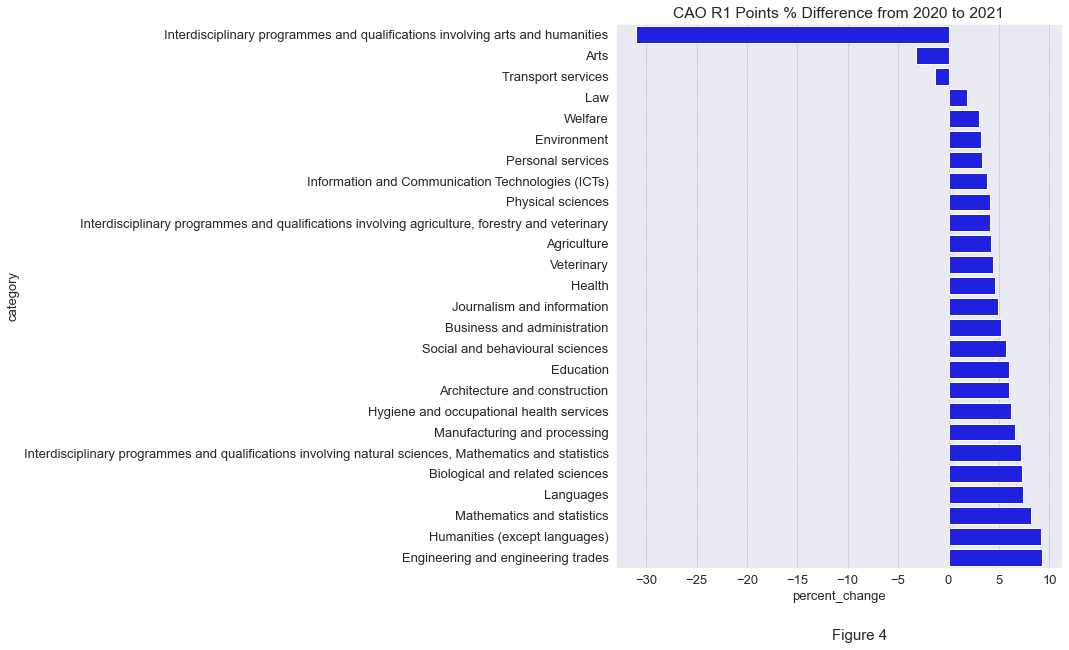

In [38]:
fig, ax = plt.subplots(figsize = (8, 10))

# sort points ascending   
category_r1_comparison.sort_values(by = 'percent_change', inplace = True)

ax = sns.barplot(data = category_r1_comparison, x = 'percent_change', y = category_r1_comparison.index, color = 'b')
plt.figtext(0.5, 0.025, 'Figure 4', wrap = True, fontsize = 15)
ax.set_title('CAO R1 Points % Difference from 2020 to 2021');

string_spacer = [' ' * 90 for i in range(5)]
print('\n{}Figure 4 shows that most categories went up in points\n\
{}by circa 5 to 10 %. This data makes sense based on the \n\
{}findings from Figure 1 and 2. Interdisciplinary programmes\n\
{}/qualifications had a dramatic 25 % decrease from year 2020\n\
{}to 2021.\n'.format(*string_spacer))  

As per the CAO website certain characters / strings are present in the points data to give more information.<br>
- Hastag symbol (#) : Course has a Test / Interview / Portfolio / Audition <br>
- Asterix symbol (*): Course was not offered to everyone.<br>


              The bar distribution and KDE plots shows that the R1 Points have somewhat of a normal distribution with
              a second mode starting to appear in 2020 at approx 500 Points (plot 2). This second mode is more prevelant 
              in 2021 (plot 3) making the distribution bi-modal due to higher points being offered on this year.

              Its also apparent that 


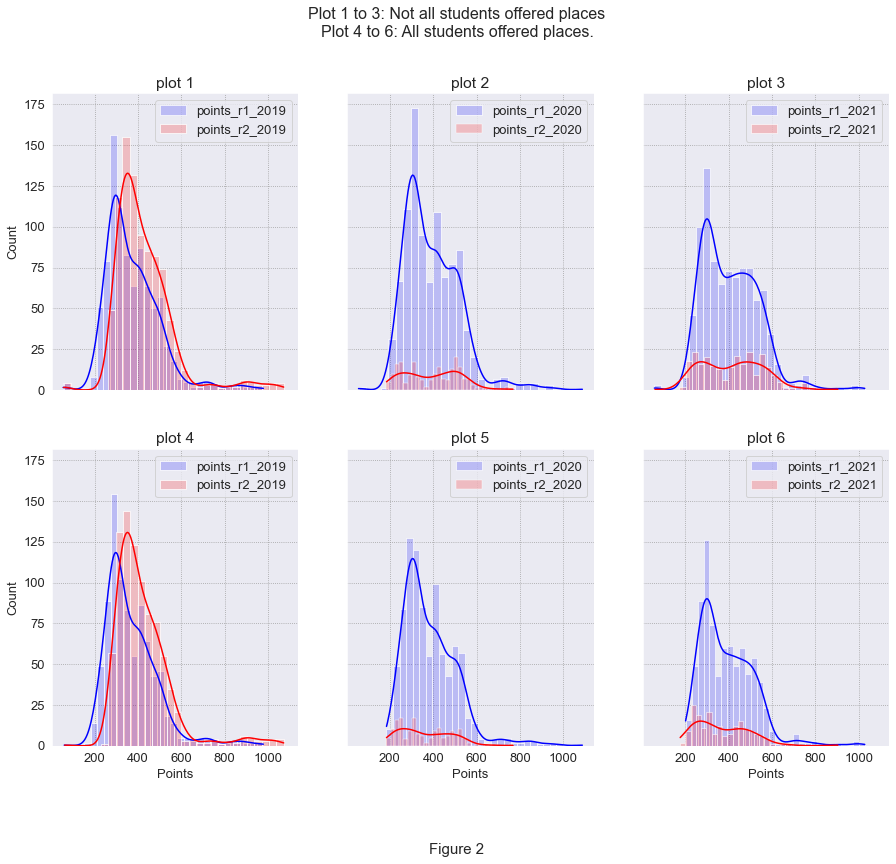

In [39]:


def plot_hist_multi(df, title, plot_ref): 
    sns.histplot(data = df, x = df.iloc[:, 0], ax = ax[plot_ref], label = df.columns[0], kde = True, 
                 color = 'blue', alpha = 0.2, bins = 30)
    
    sns.histplot(data = df, x = df.iloc[:, 1], ax = ax[plot_ref], label = df.columns[1], kde = True, 
                 color = 'red', alpha = 0.2, bins = 30)
    
    ax[plot_ref].set_xlabel('Points')    
    ax[plot_ref].title.set_text(title)
    ax[plot_ref].legend()
    

fig, ax = plt.subplots(2, 3, sharex = True, sharey = True, figsize = (15, 12))
plt.figtext(0.5, 0, 'Figure 2', wrap = True, horizontalalignment = 'center', fontsize = 15);  
fig.suptitle('Plot 1 to 3: Not all students offered places\nPlot 4 to 6: All students offered places.', fontsize=16)

#filter df for asterix character
regex = '\*|\#\*' 
df_filtered_2019 = all_courses[~all_courses['special_chars_2019'].str.contains(regex)]    
df_filtered_2020 = all_courses[~all_courses['special_chars_2020'].str.contains(regex)]
df_filtered_2021 = all_courses[~all_courses['special_chars_2021'].str.contains(regex)]

# plot  where no *asterix present
# i.e remove cases where course was not offered to everyone
plot_hist_multi(df_filtered_2019[['points_r1_2019', 'points_r2_2019']], 'plot 4', plot_ref = (1, 0))  
plot_hist_multi(df_filtered_2020[['points_r1_2020', 'points_r2_2020']], 'plot 5', plot_ref = (1, 1))  
plot_hist_multi(df_filtered_2021[['points_r1_2021', 'points_r2_2021']], 'plot 6', plot_ref = (1, 2)) 

#plot 3 years with no filter
plot_hist_multi(all_courses[['points_r1_2019', 'points_r2_2019']], 'plot 1', plot_ref = (0, 0))  
plot_hist_multi(all_courses[['points_r1_2020', 'points_r2_2020']], 'plot 2', plot_ref = (0, 1))  
plot_hist_multi(all_courses[['points_r1_2021', 'points_r2_2021']], 'plot 3', plot_ref = (0, 2)) 



string_spacer = [' ' * 14 for i in range(4)]
print('\n{}The bar distribution and KDE plots shows that the R1 Points have somewhat of a normal distribution with\n\
{}a second mode starting to appear in 2020 at approx 500 Points (plot 2). This second mode is more prevelant \n\
{}in 2021 (plot 3) making the distribution bi-modal due to higher points being offered on this year.\n\n\
{}Its also apparent that '.format(*string_spacer))

In [85]:
#df_filtered_2019

In [ ]:
add this to cao ntoebook udnerneath 

In [ ]:
# make 2, 3 grid for plotting
fig, ax = plt.subplots(2, 3, sharex = True, figsize = (15, 12))
plt.figtext(0.5, 0, 'Figure 2', wrap = True, horizontalalignment = 'center', fontsize = 15);  
fig.suptitle('Plot 1 to 3: Distribution of all courses\nPlot 4-6: Distirbution of courses where not all students were offered places', fontsize=16)


#filter df for asterix character OR 
#regex = '\*|\#\*' 
regex = '\*' 
df_filtered_2019 = all_courses[all_courses['special_chars_2019'].str.contains(regex)]    
df_filtered_2020 = all_courses[all_courses['special_chars_2020'].str.contains(regex)]
df_filtered_2021 = all_courses[all_courses['special_chars_2021'].str.contains(regex)]


# plot  where no *asterix present
# i.e remove cases where course was not offered to everyone
plot_hist_multi(df_filtered_2019[['points_r1_2019', 'points_r2_2019']], 'plot 4', plot_ref = (1, 0), bin_num = 10, y_limit = 50)  
plot_hist_multi(df_filtered_2020[['points_r1_2020', 'points_r2_2020']], 'plot 5', plot_ref = (1, 1), bin_num = 10, y_limit = 50)  
plot_hist_multi(df_filtered_2021[['points_r1_2021', 'points_r2_2021']], 'plot 6', plot_ref = (1, 2), bin_num = 10, y_limit = 50) 

#plot 3 years with no filter
plot_hist_multi(all_courses[['points_r1_2019', 'points_r2_2019']], 'plot 1', plot_ref = (0, 0), bin_num = 30, y_limit = 225)  
plot_hist_multi(all_courses[['points_r1_2020', 'points_r2_2020']], 'plot 2', plot_ref = (0, 1), bin_num = 30, y_limit = 225)  
plot_hist_multi(all_courses[['points_r1_2021', 'points_r2_2021']], 'plot 3', plot_ref = (0, 2), bin_num = 30, y_limit = 225) 



string_spacer = [' ' * 14 for i in range(6)]
print('\n{}When lookign at plot 1 to 3 the bin distribution and KDE plots shows that the Mid-Season / EOS 2019 points\n\
{}have somewhat of a right skewed normal distribution with a second mode starting to appear at approx 500\n\
{}points. In R1 2020 the mode appears more prevelant, growing even larger in R1 2021. This mode increasing\n\
{}in the higher points region of R1 2021 shows the increase in the count of higher points courses offered to\n\
{}students.\n\n\
{}Plots 4 to 6 show the distribution of courses where not all students were offered places. Interestingly the increase of points in '.format(*string_spacer))

Probability Density Section added (with 1 function) to cao notebook